## Import modules

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np 
import xarray as xr 
import yaml
from yaml import CLoader as Loader, CDumper as Dumper
from pathlib import Path
import os
import glob
import pandas as pd

import sys
sys.path.append("Y:\\Philip\\PyDDM\\PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

import gc
import statistics

import scipy
from scipy.optimize import curve_fit

## Gather info from every roi

In [3]:
master_dict = {}
    
for i in range(0,241,10):
    the_time = str(i)+'min'
    master_dict[the_time] = {}

locations = ['Y:\\Philip\\Nat\\0.5hae','Y:\\Philip\\Nat\\0.5hae(2)']
for location in locations:
    time_locations = glob.glob(location+"\\*min")
    for times_dir in time_locations:
        print("Analyzing directory: %s" % times_dir)
        the_time = times_dir.split("\\")[-1]

        ISF_files = glob.glob('%s\\*)\\*.nc' % times_dir)
        for i,files in enumerate(ISF_files):
            master_dict[the_time][files] = {}

            stuff = xr.load_dataset(files)

            master_dict[the_time][files]['tau'] = stuff.parameters.loc['Tau']
            master_dict[the_time][files]['q'] = stuff.q
            master_dict[the_time][files]['amp'] = stuff.A
            master_dict[the_time][files]['stretch'] = stuff.parameters.loc['StretchingExp']
            master_dict[the_time][files]['diffcoeff'] = stuff.effective_diffusion_coeff
            master_dict[the_time][files]['diffcoeff_std'] = stuff.diffusion_coeff_std
            master_dict[the_time][files]['alpha'] = stuff.msd_alpha
            master_dict[the_time][files]['slope'] = stuff.tau_vs_q_slope
        
np.save(locations[0]+'_master_dict.npy', master_dict, allow_pickle=True)

Analyzing directory: Y:\Philip\Nat\0.5hae\0min


C:\Users\pneill\Anaconda3\lib\site-packages\xarray\backends\plugins.py:65: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Analyzing directory: Y:\Philip\Nat\0.5hae\100min
Analyzing directory: Y:\Philip\Nat\0.5hae\10min
Analyzing directory: Y:\Philip\Nat\0.5hae\110min
Analyzing directory: Y:\Philip\Nat\0.5hae\120min
Analyzing directory: Y:\Philip\Nat\0.5hae\130min
Analyzing directory: Y:\Philip\Nat\0.5hae\140min
Analyzing directory: Y:\Philip\Nat\0.5hae\150min
Analyzing directory: Y:\Philip\Nat\0.5hae\160min
Analyzing directory: Y:\Philip\Nat\0.5hae\170min
Analyzing directory: Y:\Philip\Nat\0.5hae\180min
Analyzing directory: Y:\Philip\Nat\0.5hae\190min
Analyzing directory: Y:\Philip\Nat\0.5hae\200min
Analyzing directory: Y:\Philip\Nat\0.5hae\20min
Analyzing directory: Y:\Philip\Nat\0.5hae\210min
Analyzing directory: Y:\Philip\Nat\0.5hae\220min
Analyzing directory: Y:\Philip\Nat\0.5hae\230min
Analyzing directory: Y:\Philip\Nat\0.5hae\240min
Analyzing directory: Y:\Philip\Nat\0.5hae\30min
Analyzing directory: Y:\Philip\Nat\0.5hae\40min
Analyzing directory: Y:\Philip\Nat\0.5hae\50min
Analyzing directory: Y:\P

In [4]:
#master_dict = np.load(locations[0]+'_master_dict.npy', allow_pickle=True)

## Set parameters and trim data

In [5]:
q_min = 3
q_max = 11
q_range = slice(q_min,q_max)

slope_min = -2.2
slope_max = -1.8

y_floor1 = 0
y_ceil1 = 4

y_floor2 = 0.15
y_ceil2 = 0.25

In [6]:
trimmed_dict = {}

for i in range(0,241,10):
    the_time = str(i)+'min'
    trimmed_dict[the_time] = {}
    for files in master_dict[the_time]:
        if y_floor1 <= master_dict[the_time][files]['tau'][q_min] <= y_ceil1 and \
        y_floor2 <= master_dict[the_time][files]['tau'][q_max] <= y_ceil2:
            
            trimmed_dict[the_time][files] = {}
            
            trimmed_dict[the_time][files]['tau'] = master_dict[the_time][files]['tau']
            trimmed_dict[the_time][files]['q'] = master_dict[the_time][files]['q']
            trimmed_dict[the_time][files]['amp'] = master_dict[the_time][files]['amp']
            trimmed_dict[the_time][files]['stretch'] = master_dict[the_time][files]['stretch']
            trimmed_dict[the_time][files]['diffcoeff'] = master_dict[the_time][files]['diffcoeff']
            trimmed_dict[the_time][files]['diffcoeff_std'] = master_dict[the_time][files]['diffcoeff_std']
            trimmed_dict[the_time][files]['alpha'] = master_dict[the_time][files]['alpha']
            trimmed_dict[the_time][files]['slope'] = master_dict[the_time][files]['slope']

## Average values

In [7]:
variables = ['tau','q','amp','stretch']
for variable in variables:

    time_list = []
    for i in range(0,241,10):
        the_time = str(i)+'min'
        avg_list = []
        for qs in range(64):
            value_list = []
            for files in trimmed_dict[the_time]:
                value = trimmed_dict[the_time][files][variable][qs].values.tolist()
                value_list.append(value)
            try:
                avg = sum(value_list)/len(value_list)
            except:
                avg = 0
            avg_list.append(avg)
        time_list.append(avg_list)
    df = pd.DataFrame(time_list)
    df.to_excel(locations[0]+'\\_'+variable+'.xlsx', index=False)

In [8]:
variables = ['diffcoeff','diffcoeff_std','alpha','slope']
for variable in variables:

    time_list = []
    for i in range(0,241,10):
        the_time = str(i)+'min'
        value_list = []
        for files in trimmed_dict[the_time]:
            value = trimmed_dict[the_time][files][variable]
            value_list.append(value)
        try:
            time_val = sum(value_list)/len(value_list)
        except:
            time_val = 0
        time_list.append(time_val)
    df = pd.DataFrame(time_list)
    df.to_excel(locations[0]+'\\_'+variable+'.xlsx', index=False)

Unfiltered: 150 --> Filtered: 114


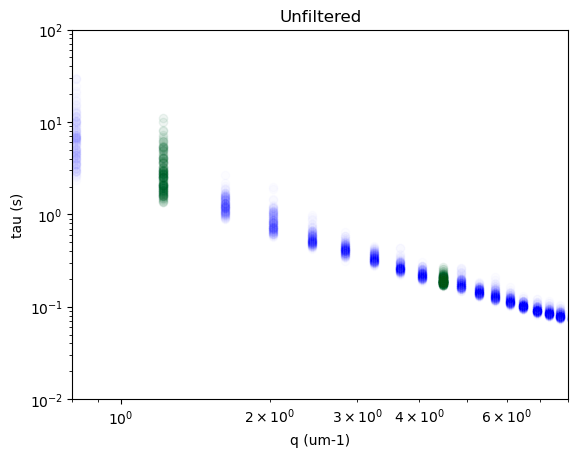

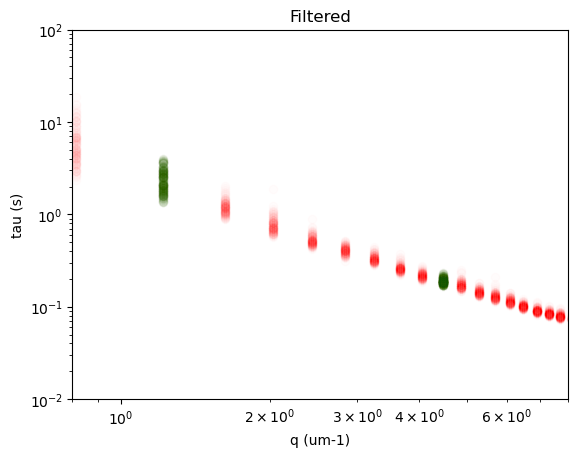

In [29]:
#%matplotlib notebook

the_time = '70min'

xbound = [0.8,8]
ybound = [0.01,100]

plt.figure()
for n,files in enumerate(master_dict[the_time]):
    plt.xlabel('q (um-1)')
    plt.ylabel('tau (s)')
    plt.title('Unfiltered')
    plt.xlim(xbound)
    plt.ylim(ybound)
    plt.loglog(master_dict[the_time][files]['q'], master_dict[the_time][files]['tau'], 'bo', alpha = 0.01)
    plt.loglog(master_dict[the_time][files]['q'][q_min], master_dict[the_time][files]['tau'][q_min], 'go', alpha = 0.05)
    plt.loglog(master_dict[the_time][files]['q'][q_max], master_dict[the_time][files]['tau'][q_max], 'go', alpha = 0.05)


plt.figure()
for i, files in enumerate(trimmed_dict[the_time]):
    plt.xlabel('q (um-1)')
    plt.ylabel('tau (s)')
    plt.title('Filtered')
    plt.xlim(xbound)
    plt.ylim(ybound)
    plt.loglog(trimmed_dict[the_time][files]['q'], trimmed_dict[the_time][files]['tau'], 'ro', alpha = 0.01)
    plt.loglog(trimmed_dict[the_time][files]['q'][q_min], master_dict[the_time][files]['tau'][q_min], 'go', alpha = 0.05)
    plt.loglog(trimmed_dict[the_time][files]['q'][q_max], master_dict[the_time][files]['tau'][q_max], 'go', alpha = 0.05)
    #plt.loglog(trimmed_dict[the_time][files]['q'], time_list[16], 'bo', alpha = 0.01)
    
print('Unfiltered: '+ str(n+1),'--> Filtered: ' + str(i+1))
plt.show()

In [49]:
D_list = []
D_std_list = []
amplitude_list = []
#D = []

for j in range(0,241,10):
    the_time = str(j)+'min'
    for i, files in enumerate(trimmed_dict[the_time]):
        D = 1/(trimmed_dict[the_time][files]['tau'][q_range]*trimmed_dict[the_time][files]['q'][q_range]**2)
        
    #Deez = np.array(D)
    means = D.mean()
    stds = D.std()
    
    D_list.append(means)
    D_std_list.append(stds)

Diff_calc = pd.DataFrame(np.array(D_list))    
Diff_std_calc = pd.DataFrame(np.array(D_std_list))

In [35]:
print(Diff_calc.to_string(index=False))

       0
0.416522
0.405221
0.343719
0.400218
0.358578
0.363962
0.355678
0.315571
0.361559
0.284536
0.318445
0.284389
0.262888
0.248007
0.376176
0.223041
0.410512
0.261082
0.267288
0.249754
0.229232
0.282869
0.303434
0.285425
0.281710


In [36]:
print(Diff_std_calc.to_string(index=False))

       0
0.035061
0.064067
0.062208
0.065266
0.047229
0.040015
0.047585
0.036968
0.045765
0.030227
0.052786
0.040630
0.033600
0.031365
0.099238
0.026075
0.067951
0.040341
0.055916
0.037533
0.037477
0.052492
0.052957
0.062691
0.048134
